# DPU example: MNIST Classifier
----

## Aim/s

This notebook shows how to deploy Convolutional Neural Network (CNN)
model for hand-written digit recognition. The network was trained on
the MNIST dataset,quantized using Vitis AI compiler tools, and
deployed on the DPU.

Compared to the other notebooks delivered in this folder, this notebook
shows how to deploy a **user-trained** DPU model on PYNQ image; i.e.,
the model used in this notebook does not come from the model zoo.

## References

* [Train your own DPU models](https://github.com/Xilinx/DPU-PYNQ/tree/master/host#train-your-own-dpu-models-from-scratch)
* [Vitis AI model zoo](https://github.com/Xilinx/Vitis-AI/tree/master/models/AI-Model-Zoo)

## Last revised
* Mar 8, 2021
    * Initial revision
----

## 0. Import needed libraries

In [37]:
from pynq_dpu import DpuOverlay
from time import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch import nn
import dsntnn
import torch
import onnxruntime as ort
import onnx
import onnxruntime.quantization as quantization

%matplotlib inline

## 1. Prepare the overlay

In [2]:
'''
Download the DPU overlay onto the board.
'''
overlay = DpuOverlay("dpu.bit")

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

In [3]:
'''
- Here we only load the feature generator and compression layers into the DPU.
- Subsequent upsampling convolutional layers do not pass verification, so we move
  those to post-processing on the CPU.
- This hurts framerate, but gurantees correctness.
'''
overlay.load_model("FeaturesAndCompressBackbone.xmodel")

## 2. Load test data

In [4]:
'''
- Image pre-processing function to prepare input data such 
  that it matches what was used during training.
'''
def rescale(image, output_size):
    image_ = image/256.0
    h, w = image_.shape[:2]
    im_scale = min(float(output_size[0]) / float(h), float(output_size[1]) / float(w))
    new_h = int(image_.shape[0] * im_scale)
    new_w = int(image_.shape[1] * im_scale)
    image = cv2.resize(image_, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    left_pad = (output_size[1] - new_w) // 2
    right_pad = (output_size[1] - new_w) - left_pad
    top_pad = (output_size[0] - new_h) // 2
    bottom_pad = (output_size[0] - new_h) - top_pad
    mean=np.array([0.485, 0.456, 0.406])
    pad = ((top_pad, bottom_pad), (left_pad, right_pad))
    image = np.stack([np.pad(image[:,:,c], pad, mode='constant', constant_values=mean[c])for c in range(3)], axis=2)
    pose_fun = lambda x: ((((x.reshape([-1,2])+np.array([1.0,1.0]))/2.0*np.array(output_size)-[left_pad, top_pad]) * 1.0 /np.array([new_w, new_h])*np.array([w,h])))
    return {'image': image, 'pose_fun': pose_fun}

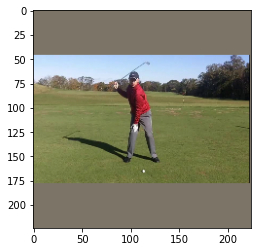

In [5]:
# Load the input image
test_img = cv2.imread('./test.jpg')

# Convert to the expected RGB format
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Apply the rescale transform
rescale_out = rescale(test_img, (224, 224))

# Show the image
plt.imshow(rescale_out['image'])
plt.show()

## 3. Use VART
Now we should be able to use VART API to do the task.

In [6]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])


print(f"Input Shape  : {shapeIn}")
print(f"Output Shape : {shapeOut}")

Input Shape  : (1, 224, 224, 3)
Output Shape : (1, 7, 7, 256)


We can define a few buffers to store input and output data.
They will be reused during multiple runs.

In [7]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

## 4. Run DPU to make predictions

We can now classify a couple of digit pictures. For each picture, 
the classification result (shown as 'Prediction') is displayed on top of 
the picture. 

In [8]:
'''
- Helper function to draw the pose wireframe onto the input image. Code from https://github.com/YuliangXiu/MobilePose.
'''
def draw_humans(npimg, pose, imgcopy=False):
    if imgcopy:
        npimg = np.copy(npimg)
    image_h, image_w = npimg.shape[:2]
    centers = {}

    colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0],
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255],
          [170, 0, 255], [255, 0, 255]]

    pairs = [[8,9],[11,12],[11,10],[2,1],[1,0],[13,14],[14,15],[3,4],[4,5],[8,7],[7,6],[6,2],[6,3],[8,12],[8,13]]
    colors_skeleton = ['r', 'y', 'y', 'g', 'g', 'y', 'y', 'g', 'g', 'm', 'm', 'g', 'g', 'y','y']
    colors_skeleton = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0],
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255],
          [170, 0, 255]]

    for idx in range(len(colors)):
        cv2.circle(npimg, (pose[idx,0], pose[idx,1]), 3, colors[idx], thickness=3, lineType=8, shift=0)
    for idx in range(len(colors_skeleton)):
        npimg = cv2.line(npimg, (pose[pairs[idx][0],0], pose[pairs[idx][0],1]), (pose[pairs[idx][1],0], pose[pairs[idx][1],1]), colors_skeleton[idx], 3)

    return npimg

'''
- Helper function to crop camera inputs to a specified ratio. Code from https://github.com/YuliangXiu/MobilePose.
'''
def crop_camera(image, ratio=0.15):
    height = image.shape[0]
    width = image.shape[1]
    mid_width = width / 2.0
    width_20 = width * ratio
    crop_img = image[0:int(height), int(mid_width - width_20):int(mid_width + width_20)]
    return crop_img

In [9]:
'''
- Upsampling convolutional layer that uses pixel shuffle. Since pixel shuffle did not pass verification, this layer
  must be run on CPU. For this, we use PyTorch. Code from https://github.com/YuliangXiu/MobilePose.
'''
class DUC(nn.Module):
    '''
    Initialize: inplanes, planes, upscale_factor
    Output: (planes // upscale_factor^2) * ht * wd
    '''

    def __init__(self, inplanes, planes, upscale_factor=2):
        super(DUC, self).__init__()
        self.conv = nn.Conv2d(
            inplanes, planes, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(planes, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pixel_shuffle(x)
        return x

In [10]:
'''
- Here we load in the pretrained weights from our MobileNetV2 pose estimator. Since most of the model is on the DPU,
  we are only interested in extracting the weights for layers running on the CPU. These include three DUC layers and
  a final convolutional layer that generates heatmaps.
'''
pretrained_weights = torch.load('mobilenetv2_224_adam_best.t7', map_location="cpu")

duc1_conv_weight = pretrained_weights['resnet.2.conv.weight']
duc1_bn_weight = pretrained_weights['resnet.2.bn.weight']
duc1_bn_bias = pretrained_weights['resnet.2.bn.bias']

duc2_conv_weight = pretrained_weights['resnet.3.conv.weight']
duc2_bn_weight = pretrained_weights['resnet.3.bn.weight']
duc2_bn_bias = pretrained_weights['resnet.3.bn.bias']

duc3_conv_weight = pretrained_weights['resnet.4.conv.weight']
duc3_bn_weight = pretrained_weights['resnet.4.bn.weight']
duc3_bn_bias = pretrained_weights['resnet.4.bn.bias']

hm_conv_weight = pretrained_weights['hm_conv.weight']

In [62]:
'''
- Here we define the three DUC layers and heatmap convolution such that they match the original training model. Then, we
  set their weights to the pretrained weights extracted in the previous step.
'''
class PostProcessor(nn.Module):
    def __init__(self):
        super(PostProcessor, self).__init__()
        self.duc1 = DUC(256, 512, upscale_factor=2)
        self.duc1.conv.weight = nn.Parameter(duc1_conv_weight)
        self.duc1.bn.weight = nn.Parameter(duc1_bn_weight)
        self.duc1.bn.bias = nn.Parameter(duc1_bn_bias)

        self.duc2 = DUC(128, 256, upscale_factor=2)
        self.duc2.conv.weight = nn.Parameter(duc2_conv_weight)
        self.duc2.bn.weight = nn.Parameter(duc2_bn_weight)
        self.duc2.bn.bias = nn.Parameter(duc2_bn_bias)

        self.duc3 = DUC(64, 128, upscale_factor=2)
        self.duc3.conv.weight = nn.Parameter(duc3_conv_weight)
        self.duc3.bn.weight = nn.Parameter(duc3_bn_weight)
        self.duc3.bn.bias = nn.Parameter(duc3_bn_bias)

        self.hm_conv = nn.Conv2d(32, 16, kernel_size=1, bias=False)
        self.hm_conv.weight = nn.Parameter(hm_conv_weight)
    
    def forward(self, x):
        x = self.duc1(x)
        x = self.duc2(x)
        x = self.duc3(x)
        unnormalized_heatmaps = self.hm_conv(x)
        heatmaps = dsntnn.flat_softmax(unnormalized_heatmaps)
        coords = dsntnn.dsnt(heatmaps)
        return coords

post_processor = PostProcessor()

In [93]:
import os
from IPython.display import clear_output

class QuantizationDataReader(quantization.CalibrationDataReader):
    def __init__(self):
        self.image_list = os.listdir('images')
        self.image_idx = 0
        
    def get_next(self):
        if self.image_idx != len(self.image_list):    
            test_img = cv2.imread('images/' + self.image_list[self.image_idx])
            # test_img = crop_camera(test_img)
            rescale_out = rescale(test_img, (224, 224))
            rescaled_input = rescale_out['image']
            image[0,...] = rescaled_input
            job_id = dpu.execute_async(input_data, output_data)
            dpu.wait(job_id)
            x = torch.tensor(np.array(output_data))[0]
            x = x.transpose(1, 3).transpose(2, 3).numpy()
            clear_output()
            print("----------------------------------------")
            print(f"processing calib image {self.image_idx}")
            print("----------------------------------------")
            self.image_idx += 1
            return {'input': x}
        else:
            return None

model_fp32_path = 'post_processing.onnx'
dummy_in = torch.randn(1, 256, 7, 7, requires_grad=True)
torch.onnx.export(post_processor,                                   # model
                  dummy_in,                                         # model input
                  model_fp32_path,                                  # path
                  export_params=True,                               # store the trained parameter weights inside the model file
                  opset_version=14,                                 # the ONNX version to export the model to
                  do_constant_folding=True,                         # constant folding for optimization
                  input_names = ['input'],                          # input names
                  output_names = ['output'],                        # output names
                  dynamic_axes={'input' : {0 : 'batch_size'},       # variable length axes
                                'output' : {0 : 'batch_size'}})

q_static_opts = {"ActivationSymmetric":False,
                 "WeightSymmetric":True}

model_prep_path = 'post_processing_prep.onnx'
quantization.shape_inference.quant_pre_process(model_fp32_path, model_prep_path, skip_symbolic_shape=False)

q_static_opts = {"ActivationSymmetric":False,
                 "WeightSymmetric":True}

qdr = QuantizationDataReader()
model_quant_path = 'post_processing_quant.onnx'
quantized_model = quantization.quantize_static(model_input=model_prep_path,
                                               model_output=model_quant_path,
                                               calibration_data_reader=qdr,
                                               extra_options=q_static_opts)

----------------------------------------
processing calib image 2357
----------------------------------------


In [110]:
trials = 25

ort_provider = ['CPUExecutionProvider']
ort_sess = ort.InferenceSession('post_processing_quant.onnx', providers=ort_provider)

start = time()
for _ in range(trials):
    # Pre-processing
    test_img = cv2.imread('./test2.jpg')
    test_img = crop_camera(test_img)
    rescale_out = rescale(test_img, (224, 224))
    rescaled_input = rescale_out['image']
    
    # Execute DPU inference
    image[0,...] = rescaled_input
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    # Extract the output from the DPU buffer and reshape it for further processing
    x = torch.tensor(np.array(output_data))[0]
    x = x.transpose(1, 3).transpose(2, 3)

    # Post-processing
    # coords = post_processor(x).detach().numpy()
    x = {ort_sess.get_inputs()[0].name: x.numpy()}
    coords = ort_sess.run(None, x)[0]
    
    coords = rescale_out['pose_fun'](coords).astype(int)
stop = time()

# # Display results
res = draw_humans(test_img, coords)
cv2.imwrite('inference_test.jpg', res)

execution_time = stop - start
print("Execution time: {:.4f}s".format(execution_time))
print("Throughput: {:.4f}FPS".format(trials/execution_time))

Execution time: 2.3965s
Throughput: 10.4318FPS


## 5. Pure CPU Test Using a Quantized ONNX Model

In [114]:
trials = 25

ort_provider = ['CPUExecutionProvider']
ort_sess = ort.InferenceSession('mobile_pose_int8.onnx', providers=ort_provider)

start = time()
for _ in range(trials):
    # Pre-processing
    test_img = cv2.imread('./test2.jpg')
    test_img = crop_camera(test_img)
    rescale_out = rescale(test_img, (224, 224))
    rescaled_input = np.expand_dims(np.reshape(rescale_out['image'].astype(np.float32), (3, 224, 224)), axis=0)
    
    ort_inputs = {ort_sess.get_inputs()[0].name: rescaled_input}
    ort_outs = ort_sess.run(None, ort_inputs)[0]
    
    coords = rescale_out['pose_fun'](coords).astype(int)
stop = time()

execution_time = stop - start
print("Execution time: {:.4f}s".format(execution_time))
print("Throughput: {:.4f}FPS".format(trials/execution_time))

Execution time: 3.2367s
Throughput: 7.7238FPS


## 6. Clean up

We will need to remove references to `vart.Runner` and let Python garbage-collect
the unused graph objects. This will make sure we can run other notebooks without
any issue.

In [115]:
del overlay
del dpu

NameError: name 'overlay' is not defined

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----